<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Sequential_CNN(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -*- coding: utf-8 -*-
# Sequential CNN for Crop Production Classification (3 Classes: Low, Medium, High)

# This script demonstrates how to build and train a Sequential 1D
# Convolutional Neural Network (CNN) for classifying crop production levels
# based on tabular data using TensorFlow/Keras.

## 1. Setup and Imports

# Import necessary libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (optional, if data is stored there)
# from google.colab import drive
# drive.mount("/content/drive")

# Define file paths (adjust based on your data location)
TRAIN_PATH = "/content/drive/MyDrive/UpdatedDataset/train.csv"  # Updated to local path
VALID_PATH = "/content/drive/MyDrive/UpdatedDataset/validation.csv"
TEST_PATH = "/content/drive/MyDrive/UpdatedDataset/test.csv"

# Alternative paths for Google Drive:
# TRAIN_PATH = "/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv"
# VALID_PATH = "/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv"
# TEST_PATH = "/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv"



In [3]:

## 2. Load and Preprocess Data

# Global variable to store quantile boundaries
quantile_bins = None

# Load the datasets and apply preprocessing steps.
def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False, is_training=False):
    """Loads data, preprocesses features, and converts target to 3 classes (Low, Medium, High)."""
    global quantile_bins

    df = pd.read_csv(file_path)

    # Define class boundaries based on quantiles (tertiles for 3 classes)
    if is_training:
        # Calculate quantiles from training data for 3 classes
        production_values = df["Production (M.Ton)"]
        quantiles = [0.0, 0.33, 0.67, 1.0]  # 3 equal groups (tertiles)
        quantile_bins = production_values.quantile(quantiles).tolist()
        quantile_bins[0] = -np.inf  # Ensure first bin captures all values
        quantile_bins[-1] = np.inf  # Ensure last bin captures all values

        print(f"Quantile boundaries: {quantile_bins}")
        print(f"Low: < {quantile_bins[1]:.2f}")
        print(f"Medium: {quantile_bins[1]:.2f} - {quantile_bins[2]:.2f}")
        print(f"High: >= {quantile_bins[2]:.2f}")

    if quantile_bins is None:
        raise ValueError("Quantile bins not defined. Training data must be processed first.")

    labels = [0, 1, 2]  # Low, Medium, High

    # Convert target variable to classes using quantile-based bins
    df["Production_Class"] = pd.cut(df["Production (M.Ton)"], bins=quantile_bins, labels=labels, right=True, include_lowest=True)

    # Check for any NaN values in Production_Class and handle them
    if df["Production_Class"].isna().any():
        print(f"Warning: {df['Production_Class'].isna().sum()} NaN values found in Production_Class. Dropping these rows.")
        df = df.dropna(subset=["Production_Class"])

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Class"], axis=1)
    y = df["Production_Class"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        X[numerical_cols] = scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # Convert labels to one-hot encoding
    y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(labels))

    # Reshape features for 1D CNN: (samples, features, 1)
    X_reshaped = X.values.reshape((X.shape[0], X.shape[1], 1))

    if fit_scaler and fit_encoder:
        return X_reshaped, y_one_hot, scaler, label_encoder
    elif fit_scaler:
         return X_reshaped, y_one_hot, scaler
    elif fit_encoder:
        return X_reshaped, y_one_hot, label_encoder
    else:
        return X_reshaped, y_one_hot

# Load and preprocess data
print("Loading and preprocessing training data...")
X_train, y_train, scaler, label_encoder = load_and_preprocess(TRAIN_PATH, fit_scaler=True, fit_encoder=True, is_training=True)
print("\nLoading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(VALID_PATH, scaler=scaler, label_encoder=label_encoder)
print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(TEST_PATH, scaler=scaler, label_encoder=label_encoder)

print(f"\nTraining data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")

# Print class distribution in training data
print("\nClass distribution in training data:")
y_train_labels = np.argmax(y_train, axis=1)
class_counts = np.bincount(y_train_labels)
class_names = ['Low', 'Medium', 'High']  # Updated to 3 classes
for i, (name, count) in enumerate(zip(class_names, class_counts)):
    percentage = (count / len(y_train_labels)) * 100
    print(f"Class {i} ({name}): {count} samples ({percentage:.1f}%)")






Loading and preprocessing training data...
Quantile boundaries: [-inf, 1071.5565, 4035.9099, inf]
Low: < 1071.56
Medium: 1071.56 - 4035.91
High: >= 4035.91

Loading and preprocessing validation data...
Loading and preprocessing test data...

Training data shape: (3942, 83, 1), Labels shape: (3942, 3)
Validation data shape: (845, 83, 1), Labels shape: (845, 3)
Test data shape: (845, 83, 1), Labels shape: (845, 3)
Number of classes: 3

Class distribution in training data:
Class 0 (Low): 1301 samples (33.0%)
Class 1 (Medium): 1340 samples (34.0%)
Class 2 (High): 1301 samples (33.0%)


In [4]:

## 3. Build the 1D CNN Model

# Define the architecture of the Sequential 1D CNN (optimized for 3 classes).
def build_cnn_model(input_shape, num_classes):
    """Builds the Sequential 1D CNN model optimized for 3-class classification."""
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            # Convolutional Block 1
            layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            # Convolutional Block 2
            layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            # Convolutional Block 3 (simplified for 3 classes)
            layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            # Flatten and Dense Layers
            layers.Flatten(),
            layers.Dense(128, activation="relu"),  # Reduced complexity for 3 classes
            layers.Dropout(0.5),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"), # Output layer for 3-class classification
        ]
    )
    return model

# Get input shape and number of classes from preprocessed data
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

# Build the model
model = build_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 83, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 83, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 41, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,939 (968.51 KB)

 Trainable params: 247,299 (966.01 KB)

 Non-trainable params: 640 (2.50 KB)

In [5]:
## 4. Train the Model

# Train the CNN using the training and validation datasets.

# Define training parameters
EPOCHS = 60  # Adjusted epochs for 3-class classification
BATCH_SIZE = 32

# Add Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Add Learning Rate Reduction
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3597 - loss: 1.5495 - val_accuracy: 0.3112 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 2/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.3339 - loss: 1.1242 - val_accuracy: 0.3905 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 3/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.3923 - loss: 1.0911 - val_accuracy: 0.5124 - val_loss: 1.0552 - learning_rate: 0.0010
Epoch 4/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.4715 - loss: 1.0281 - val_accuracy: 0.5680 - val_loss: 0.9758 - learning_rate: 0.0010
Epoch 5/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4980 - loss: 0.9615 - val_accuracy: 0.6047 - val_loss: 0.8634 - learning_rate: 0.0010
Epoch 6/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5656 - loss: 0.8975 - val_accuracy: 0.6391 - val_loss: 0.7873 - learning_rate: 0.0010
Epoch 7/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5751 - loss: 0

In [6]:
## 5. Evaluate the Model

# Get best validation accuracy from history
if 'val_accuracy' in history.history:
    best_val_accuracy = max(history.history['val_accuracy'])
    print(f"\nBest Validation Accuracy during Training: {best_val_accuracy:.4f}")
else:
    print("\nValidation accuracy not available in history.")


Best Validation Accuracy during Training: 0.8982


In [7]:

# =====================================
# COMPREHENSIVE VALIDATION SET EVALUATION
# =====================================
print("\n" + "="*70)
print("COMPREHENSIVE VALIDATION SET EVALUATION")
print("="*70)

# Basic model evaluation on validation set
print("\n1. Basic Model Performance on Validation Set:")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"   Validation Loss: {val_loss:.4f}")
print(f"   Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions on validation set
print("\n2. Generating Predictions on Validation Set...")
y_val_pred_proba = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Calculate comprehensive validation metrics
print("\n3. Comprehensive Validation Set Metrics:")
val_precision_macro = precision_score(y_val_labels, y_val_pred, average='macro')
val_precision_weighted = precision_score(y_val_labels, y_val_pred, average='weighted')
val_recall_macro = recall_score(y_val_labels, y_val_pred, average='macro')
val_recall_weighted = recall_score(y_val_labels, y_val_pred, average='weighted')
val_f1_macro = f1_score(y_val_labels, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val_labels, y_val_pred, average='weighted')

print(f"   Accuracy: {val_accuracy:.4f}")
print(f"   Precision (Macro): {val_precision_macro:.4f}")
print(f"   Precision (Weighted): {val_precision_weighted:.4f}")
print(f"   Recall (Macro): {val_recall_macro:.4f}")
print(f"   Recall (Weighted): {val_recall_weighted:.4f}")
print(f"   F1 Score (Macro): {val_f1_macro:.4f}")
print(f"   F1 Score (Weighted): {val_f1_weighted:.4f}")


cm_val = confusion_matrix(y_val_labels, y_val_pred)


# Per-class validation metrics
print("\n5. Validation Set - Per-Class Performance:")
val_per_class_precision = precision_score(y_val_labels, y_val_pred, average=None)
val_per_class_recall = recall_score(y_val_labels, y_val_pred, average=None)
val_per_class_f1 = f1_score(y_val_labels, y_val_pred, average=None)

for i in range(len(class_names)):
    class_accuracy = cm_val[i, i] / cm_val[i].sum() if cm_val[i].sum() > 0 else 0
    print(f"   {class_names[i]}:")
    print(f"     Accuracy: {class_accuracy:.4f}")
    print(f"     Precision: {val_per_class_precision[i]:.4f}")
    print(f"     Recall: {val_per_class_recall[i]:.4f}")
    print(f"     F1-Score: {val_per_class_f1[i]:.4f}")

# Detailed validation classification report
print("\n6. Validation Set - Detailed Classification Report:")
print(classification_report(y_val_labels, y_val_pred, target_names=class_names))

# Validation class distribution analysis
print("\n7. Validation Set - Class Distribution Analysis:")
y_val_counts = np.bincount(y_val_labels)
y_val_pred_counts = np.bincount(y_val_pred)
print(f"   True Distribution: {dict(zip(class_names, y_val_counts))}")
print(f"   Predicted Distribution: {dict(zip(class_names, y_val_pred_counts))}")




COMPREHENSIVE VALIDATION SET EVALUATION

1. Basic Model Performance on Validation Set:
   Validation Loss: 0.2799
   Validation Accuracy: 0.8923

2. Generating Predictions on Validation Set...

3. Comprehensive Validation Set Metrics:
   Accuracy: 0.8923
   Precision (Macro): 0.8959
   Precision (Weighted): 0.8944
   Recall (Macro): 0.8929
   Recall (Weighted): 0.8923
   F1 Score (Macro): 0.8940
   F1 Score (Weighted): 0.8929

5. Validation Set - Per-Class Performance:
   Low:
     Accuracy: 0.8993
     Precision: 0.9542
     Recall: 0.8993
     F1-Score: 0.9259
   Medium:
     Accuracy: 0.8721
     Precision: 0.8328
     Recall: 0.8721
     F1-Score: 0.8520
   High:
     Accuracy: 0.9074
     Precision: 0.9007
     Recall: 0.9074
     F1-Score: 0.9041

6. Validation Set - Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.90      0.93       278
      Medium       0.83      0.87      0.85       297
        High       0

In [8]:
# =====================================
# COMPREHENSIVE TEST SET EVALUATION
# =====================================
print("\n" + "="*70)
print("COMPREHENSIVE TEST SET EVALUATION")
print("="*70)

# Basic model evaluation on test set
print("\n1. Basic Model Performance on Test Set:")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f}")

# Generate predictions on test set
print("\n2. Generating Predictions on Test Set...")
y_test_pred_proba = model.predict(X_test, verbose=0)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate comprehensive test metrics
print("\n3. Comprehensive Test Set Metrics:")
test_precision_macro = precision_score(y_test_labels, y_test_pred, average='macro')
test_precision_weighted = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall_macro = recall_score(y_test_labels, y_test_pred, average='macro')
test_recall_weighted = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1_macro = f1_score(y_test_labels, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test_labels, y_test_pred, average='weighted')

print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   Precision (Macro): {test_precision_macro:.4f}")
print(f"   Precision (Weighted): {test_precision_weighted:.4f}")
print(f"   Recall (Macro): {test_recall_macro:.4f}")
print(f"   Recall (Weighted): {test_recall_weighted:.4f}")
print(f"   F1 Score (Macro): {test_f1_macro:.4f}")
print(f"   F1 Score (Weighted): {test_f1_weighted:.4f}")

# Generate and display test confusion matrix

cm_test = confusion_matrix(y_test_labels, y_test_pred)


# Per-class test metrics
print("\n5. Test Set - Per-Class Performance:")
test_per_class_precision = precision_score(y_test_labels, y_test_pred, average=None)
test_per_class_recall = recall_score(y_test_labels, y_test_pred, average=None)
test_per_class_f1 = f1_score(y_test_labels, y_test_pred, average=None)

for i in range(len(class_names)):
    class_accuracy = cm_test[i, i] / cm_test[i].sum() if cm_test[i].sum() > 0 else 0
    print(f"   {class_names[i]}:")
    print(f"     Accuracy: {class_accuracy:.4f}")
    print(f"     Precision: {test_per_class_precision[i]:.4f}")
    print(f"     Recall: {test_per_class_recall[i]:.4f}")
    print(f"     F1-Score: {test_per_class_f1[i]:.4f}")

# Detailed test classification report
print("\n6. Test Set - Detailed Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=class_names))


COMPREHENSIVE TEST SET EVALUATION

1. Basic Model Performance on Test Set:
   Test Loss: 0.2775
   Test Accuracy: 0.9124

2. Generating Predictions on Test Set...

3. Comprehensive Test Set Metrics:
   Accuracy: 0.9124
   Precision (Macro): 0.9138
   Precision (Weighted): 0.9135
   Recall (Macro): 0.9124
   Recall (Weighted): 0.9124
   F1 Score (Macro): 0.9129
   F1 Score (Weighted): 0.9128

5. Test Set - Per-Class Performance:
   Low:
     Accuracy: 0.9270
     Precision: 0.9621
     Recall: 0.9270
     F1-Score: 0.9442
   Medium:
     Accuracy: 0.8857
     Precision: 0.8611
     Recall: 0.8857
     F1-Score: 0.8732
   High:
     Accuracy: 0.9244
     Precision: 0.9181
     Recall: 0.9244
     F1-Score: 0.9212

6. Test Set - Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.96      0.93      0.94       274
      Medium       0.86      0.89      0.87       280
        High       0.92      0.92      0.92       291

    accuracy 

Text(0.5, 0, 'Epoch')

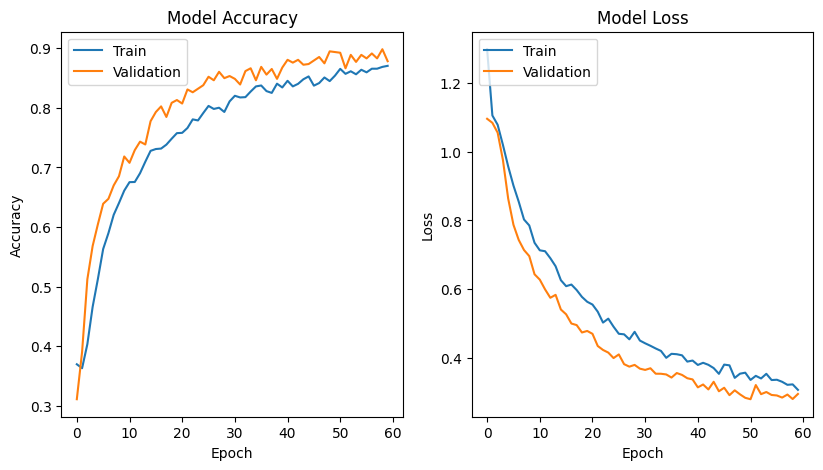

In [9]:

## 6. Visualize Results

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history["accuracy"])
if 'val_accuracy' in history.history:
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.subplot(1, 3, 2)
plt.plot(history.history["loss"])
if 'val_loss' in history.history:
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")


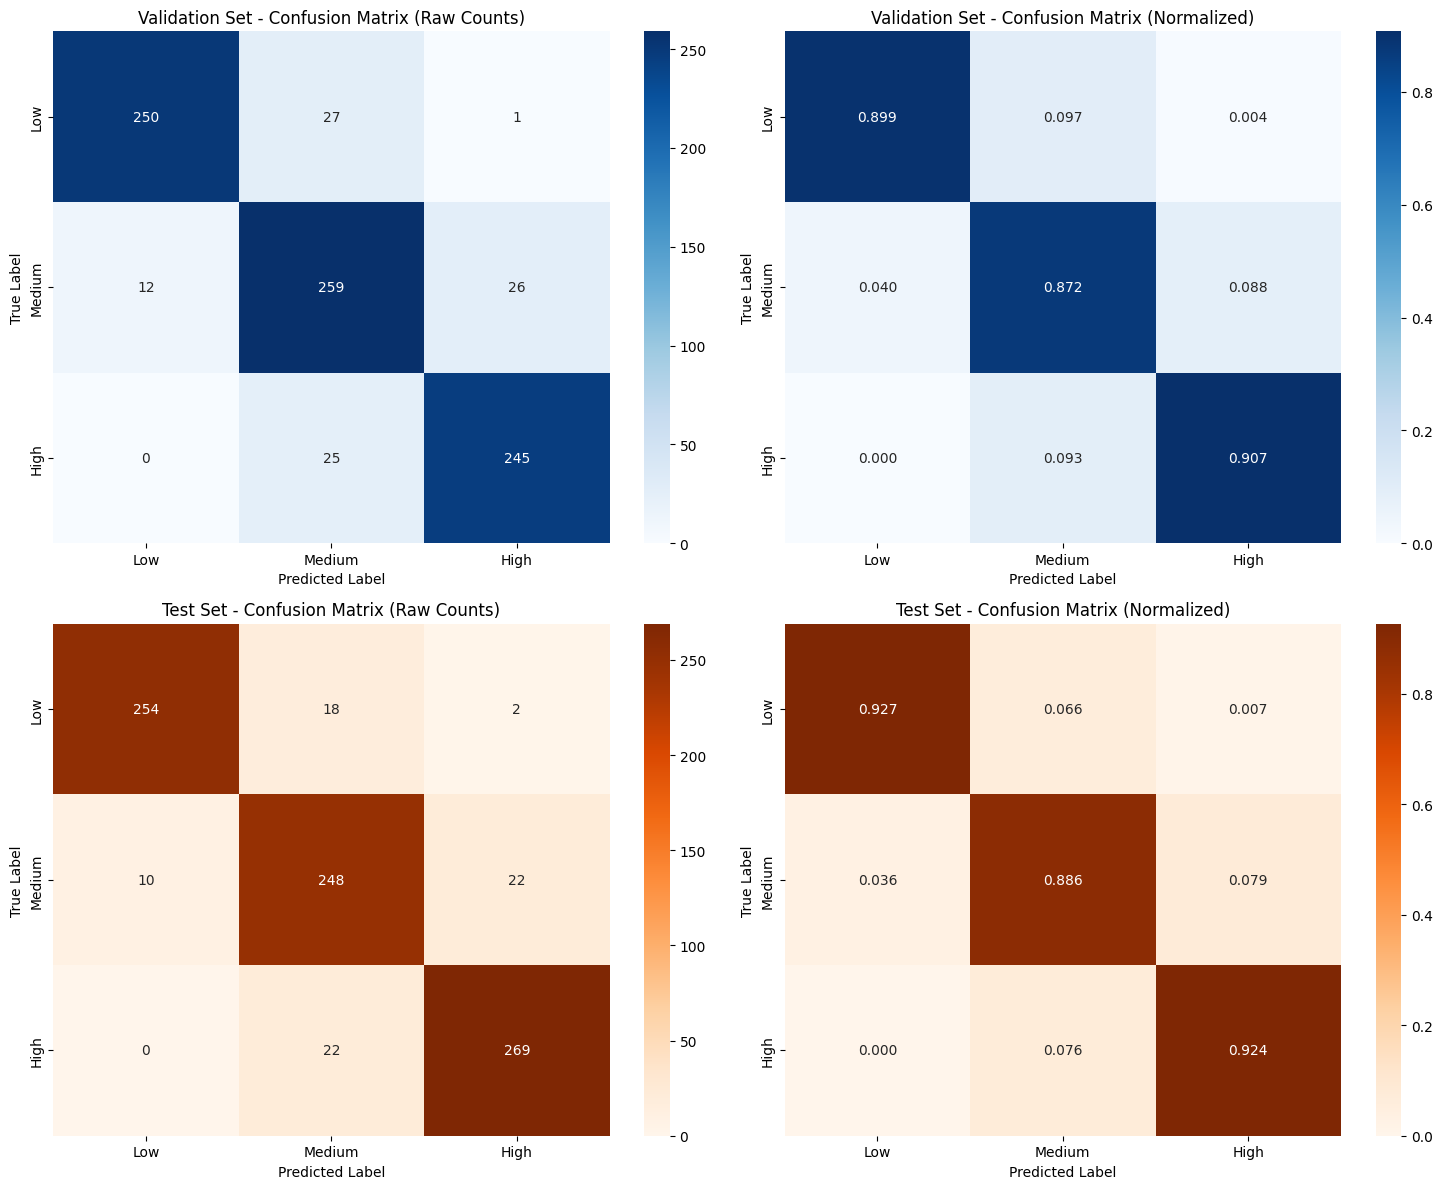

In [10]:
# Enhanced Confusion Matrix Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Validation confusion matrix - Raw counts
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
axes[0,0].set_title("Validation Set - Confusion Matrix (Raw Counts)")
axes[0,0].set_ylabel("True Label")
axes[0,0].set_xlabel("Predicted Label")

# Validation confusion matrix - Normalized
cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_val_norm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
axes[0,1].set_title("Validation Set - Confusion Matrix (Normalized)")
axes[0,1].set_ylabel("True Label")
axes[0,1].set_xlabel("Predicted Label")


# Test confusion matrix - Raw counts
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,0])
axes[1,0].set_title("Test Set - Confusion Matrix (Raw Counts)")
axes[1,0].set_ylabel("True Label")
axes[1,0].set_xlabel("Predicted Label")

# Test confusion matrix - Normalized
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_norm, annot=True, fmt=".3f", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,1])
axes[1,1].set_title("Test Set - Confusion Matrix (Normalized)")
axes[1,1].set_ylabel("True Label")
axes[1,1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()


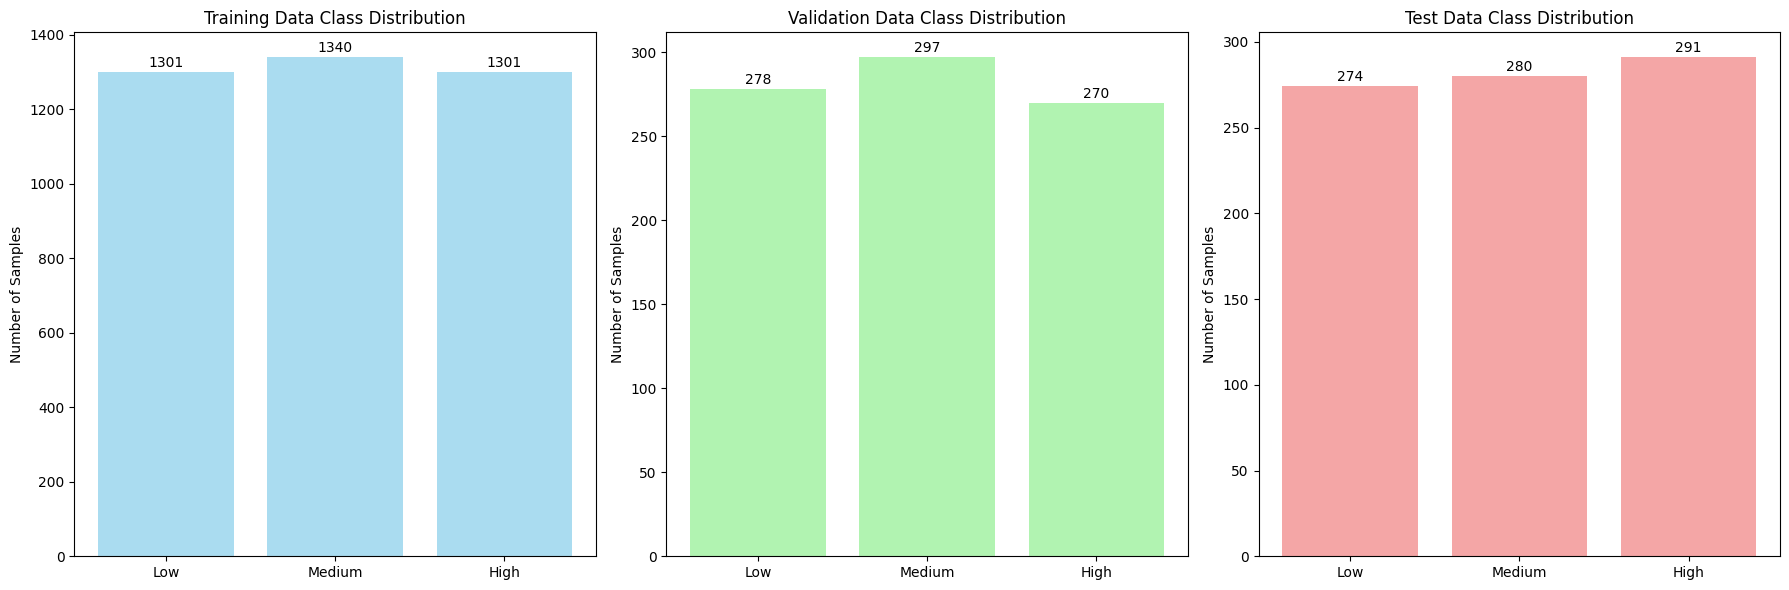

In [11]:

# Class distribution comparison
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(class_names, class_counts, color='skyblue', alpha=0.7)
plt.title("Training Data Class Distribution")
plt.ylabel("Number of Samples")
for i, count in enumerate(class_counts):
    plt.text(i, count + max(class_counts)*0.01, str(count), ha='center')

plt.subplot(1, 3, 2)
plt.bar(class_names, y_val_counts, color='lightgreen', alpha=0.7)
plt.title("Validation Data Class Distribution")
plt.ylabel("Number of Samples")
for i, count in enumerate(y_val_counts):
    plt.text(i, count + max(y_val_counts)*0.01, str(count), ha='center')

plt.subplot(1, 3, 3)
y_test_counts = np.bincount(y_test_labels)
plt.bar(class_names, y_test_counts, color='lightcoral', alpha=0.7)
plt.title("Test Data Class Distribution")
plt.ylabel("Number of Samples")
for i, count in enumerate(y_test_counts):
    plt.text(i, count + max(y_test_counts)*0.01, str(count), ha='center')

plt.tight_layout()
plt.show()


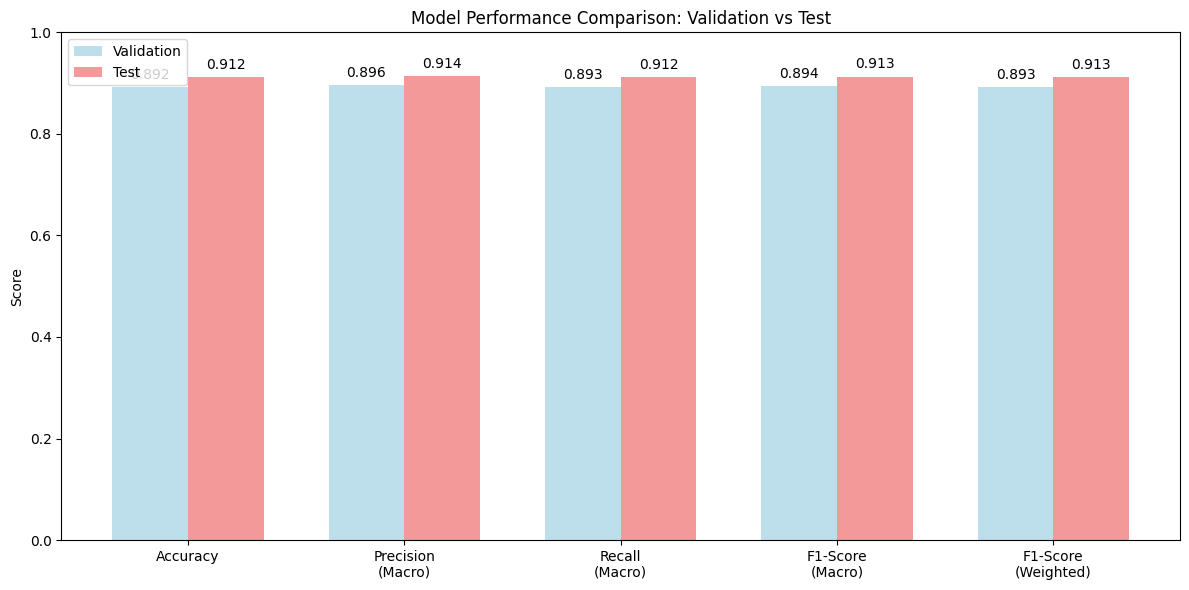

In [12]:

# Performance Comparison Visualization
metrics_names = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)', 'F1-Score\n(Weighted)']
val_metrics = [val_accuracy, val_precision_macro, val_recall_macro, val_f1_macro, val_f1_weighted]
test_metrics = [test_accuracy, test_precision_macro, test_recall_macro, test_f1_macro, test_f1_weighted]

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, val_metrics, width, label='Validation', alpha=0.8, color='lightblue')
plt.bar(x + width/2, test_metrics, width, label='Test', alpha=0.8, color='lightcoral')

plt.ylabel('Score')
plt.title('Model Performance Comparison: Validation vs Test')
plt.xticks(x, metrics_names)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for i, (val_metric, test_metric) in enumerate(zip(val_metrics, test_metrics)):
    plt.text(i - width/2, val_metric + 0.01, f'{val_metric:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, test_metric + 0.01, f'{test_metric:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:

# =====================================
# FINAL COMPREHENSIVE SUMMARY
# =====================================
print("\n" + "="*90)
print("FINAL COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*90)

print(f"{'Metric':<20} {'Validation':<15} {'Test':<15} {'Difference':<15}")
print("-" * 65)
print(f"{'Accuracy':<20} {val_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(val_accuracy-test_accuracy):<15.4f}")
print(f"{'Precision (Macro)':<20} {val_precision_macro:<15.4f} {test_precision_macro:<15.4f} {abs(val_precision_macro-test_precision_macro):<15.4f}")
print(f"{'Precision (Weighted)':<20} {val_precision_weighted:<15.4f} {test_precision_weighted:<15.4f} {abs(val_precision_weighted-test_precision_weighted):<15.4f}")
print(f"{'Recall (Macro)':<20} {val_recall_macro:<15.4f} {test_recall_macro:<15.4f} {abs(val_recall_macro-test_recall_macro):<15.4f}")
print(f"{'Recall (Weighted)':<20} {val_recall_weighted:<15.4f} {test_recall_weighted:<15.4f} {abs(val_recall_weighted-test_recall_weighted):<15.4f}")
print(f"{'F1-Score (Macro)':<20} {val_f1_macro:<15.4f} {test_f1_macro:<15.4f} {abs(val_f1_macro-test_f1_macro):<15.4f}")
print(f"{'F1-Score (Weighted)':<20} {val_f1_weighted:<15.4f} {test_f1_weighted:<15.4f} {abs(val_f1_weighted-test_f1_weighted):<15.4f}")
print(f"{'Loss':<20} {val_loss:<15.4f} {test_loss:<15.4f} {abs(val_loss-test_loss):<15.4f}")

print(f"\nQuantile boundaries used for 3-class classification:")
print(f"Low: < {quantile_bins[1]:.2f}")
print(f"Medium: {quantile_bins[1]:.2f} - {quantile_bins[2]:.2f}")
print(f"High: >= {quantile_bins[2]:.2f}")

# Model generalization assessment
avg_diff = np.mean([abs(val_accuracy-test_accuracy), abs(val_f1_macro-test_f1_macro), abs(val_f1_weighted-test_f1_weighted)])
print(f"\nModel Generalization Assessment:")
print(f"Average performance difference between validation and test: {avg_diff:.4f}")
if avg_diff < 0.02:
    print("✓ Excellent generalization - Very similar performance on validation and test sets")
elif avg_diff < 0.05:
    print("✓ Good generalization - Small differences between validation and test performance")
elif avg_diff < 0.10:
    print("⚠ Moderate generalization - Some differences between validation and test performance")
else:
    print("⚠ Poor generalization - Significant differences between validation and test performance")

print("\n--- End of Enhanced Script ---")


FINAL COMPREHENSIVE PERFORMANCE SUMMARY
Metric               Validation      Test            Difference     
-----------------------------------------------------------------
Accuracy             0.8923          0.9124          0.0201         
Precision (Macro)    0.8959          0.9138          0.0179         
Precision (Weighted) 0.8944          0.9135          0.0190         
Recall (Macro)       0.8929          0.9124          0.0195         
Recall (Weighted)    0.8923          0.9124          0.0201         
F1-Score (Macro)     0.8940          0.9129          0.0189         
F1-Score (Weighted)  0.8929          0.9128          0.0198         
Loss                 0.2799          0.2775          0.0025         

Quantile boundaries used for 3-class classification:
Low: < 1071.56
Medium: 1071.56 - 4035.91
High: >= 4035.91

Model Generalization Assessment:
Average performance difference between validation and test: 0.0196
✓ Excellent generalization - Very similar performance on va